# Arima: Forecasting the Next 25 States

### Import Packages

In [1]:
import re
import pandas as pd
import pmdarima as pmd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import classification_report

### Prepare Data

In [2]:
# file names
## training
### subjects 1-30
train_subject_f = "UCI_HAR_Dataset/train/subject_train.txt"
### features
x_train_f = "UCI_HAR_Dataset/train/X_train.txt"
### classification 
y_train_f = "UCI_HAR_Dataset/train/y_train.txt"

## testing
### subjects 1-30
test_subject_f = "UCI_HAR_Dataset/test/subject_test.txt"
### features
x_test_f = "UCI_HAR_Dataset/test/X_test.txt"
### classification 
y_test_f = "UCI_HAR_Dataset/test/y_test.txt"

In [3]:
# training data frames
train_subject_df = pd.read_csv(train_subject_f, sep=' ', header=None)
x_train_df = pd.read_fwf(x_train_f, header=None)
y_train_df = pd.read_csv(y_train_f, sep=' ', header=None)

# testing dataframes
test_subject_df = pd.read_csv(test_subject_f, sep=' ', header=None)
x_test_df = pd.read_fwf(x_test_f, header=None)
y_test_df = pd.read_csv(y_test_f, sep=' ', header=None)

In [4]:
# combine subject information with training/testing data frames
x_train_df.insert(0, "Subject", train_subject_df)
y_train_df.insert(0, "Subject", train_subject_df)
x_test_df.insert(0, "Subject", test_subject_df)
y_test_df.insert(0, "Subject", test_subject_df)

In [5]:
# get list of features
# read the file 
features_file = open("UCI_HAR_Dataset/features.txt", "r") 
features_txt = features_file.read() 
  
# create list - one entry for each new line in file 
features_list = features_txt.split("\n") 
features_file.close() 

# remove last entry ' '
features_list.pop();

In [6]:
# clean the strings, add in first column (subject)
features_fixed = [re.split("\s", elem, 1)[1] for elem in features_list]
features_fixed.insert(0, "Subject")

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/6g/lht9tm8x1bz3sdrs0xk_d2m00000gn/T/ipykernel_29457/3421664769.py:2: SyntaxWarning: invalid escape sequence '\s'
  features_fixed = [re.split("\s", elem, 1)[1] for elem in features_list]


In [7]:
# remove fourier transform columns, and keep only mean measurements + subject column
indices = [((elem[0] != 'f') and (('mean' in elem) or ('ubject' in elem))) 
           for elem in features_fixed]
x_train_df = x_train_df[x_train_df.columns[indices]]
x_test_df = x_test_df[x_test_df.columns[indices]]

In [8]:
# combine testing and training data frames into one
y_all_data = pd.concat([y_train_df, y_test_df], axis=0)
x_all_data = pd.concat([x_train_df, x_test_df], axis=0)

### Building an Optimized Arima Model Per Subject

In [9]:
# function to build arima model with optimized p,d,q parameters
def arimamodel(timeseries_array, exog_vars):
    autoarima_model = pmd.auto_arima(timeseries_array,
                                     exog_vars,
                                     start_p=1, 
                                     start_q=1,
                                     test="adf",
                                     trace=True)
    return autoarima_model

In [10]:
# empty dataframe for predictions, original results, and AIC
predictions = pd.DataFrame()
testing = pd.DataFrame()
aic = pd.DataFrame()

In [11]:
# loop through each subject, create an optimized model, and capture the predictions and AIC
for i in range(1, len(y_all_data["Subject"].unique())+1):
    # get all entries for given subject
    y_all_data_i = y_all_data[y_all_data["Subject"] == i]
    x_all_data_i = x_all_data[x_all_data["Subject"] == i]
    # last 25 observations as forecasting, rest is training
    y_i_train = y_all_data_i[:(np.shape(y_all_data_i)[0]-25)]
    y_i_test = y_all_data_i[(np.shape(y_all_data_i)[0]-25):]
    x_i_train = x_all_data_i[:(np.shape(x_all_data_i)[0]-25)]
    x_i_test = x_all_data_i[(np.shape(x_all_data_i)[0]-25):]
    # record original state
    testing[str(i)] = y_i_test[0].values
    # testing arimax on all features, only on current subject
    arima_model = arimamodel(y_i_train[0], x_i_train.loc[:, x_i_train.columns != "Subject"])
    # record predicted state
    pred_i = arima_model.predict(len(y_i_test), x_i_test.loc[:, x_i_test.columns != "Subject"])
    pred_i = pred_i.reset_index(drop=True)
    predictions[str(i)] = pred_i
    # record AIC
    aic.at[i,"aic"] = arima_model.aic()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=60.067, Time=0.96 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=726.609, Time=0.62 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=66.207, Time=0.57 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=433.725, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=756.290, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=63.098, Time=0.90 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=62.236, Time=1.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=292.208, Time=0.97 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=61.389, Time=0.78 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=62.563, Time=1.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=68.684, Time=0.75 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 8.892 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=89.130, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=87.308, Time=0.31 sec
 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=66.193, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64.611, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=65.202, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=65.427, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.633, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.755 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=94.333, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=499.900, Time=0.56 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=95.336, Time=0.55 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=335.557, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=507.313, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=95.673, Time=0.75 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=98.902, Time=1.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=268.861, Time=0.99 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=86.149, Time=0.80 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=103.633, Time=0.95 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=97.354, Time=1.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.77 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 9.317 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38.388, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.348, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.765, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=38.194, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.505, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.143 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-47.160, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=575.662, Time=0.53 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-48.477, Time=0.56 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=370.293, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=574.003, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-48.382, Time=0.81 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-45.165, Time=0.82 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.48 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 4.990 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=72.985, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=75.158, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72.162, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=71.668, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.264, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=73.356, Time=1.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=75.344, Time=1.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=69.729, Time=0.70 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=71.021, Time=0.84 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=71.428, Time=0.93 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=70.227, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=73.415, Time=1.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 8.858 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=101.546, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=504.661, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=105.778, Time=0.55 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=333.984, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=519.800, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=108.577, Time=0.80 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=107.757, Time=1.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=260.935, Time=0.96 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=105.969, Time=0.80 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=115.772, Time=1.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=104.458, Time=0.76 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 8.269 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=82.576, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.681, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=81.680, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=81.680, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=77.697, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.721 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=105.067, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=535.262, Time=0.55 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=107.455, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=366.017, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=643.771, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=108.841, Time=0.87 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=108.487, Time=1.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=287.106, Time=1.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=106.640, Time=0.72 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=107.963, Time=1.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=103.420, Time=0.81 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=411.369, Time=0.68 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=104.146, Time=0.62 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=110.345, Time=0.81 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=102.460, Time=0.92 sec
 ARIMA(0,0,2)(0,0,0)[0]  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-61.202, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-60.093, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-62.778, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-62.300, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.078, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-61.598, Time=0.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-59.600, Time=0.90 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-64.761, Time=0.58 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-63.585, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-63.205, Time=0.85 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-64.286, Time=0.89 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-61.584, Time=0.86 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 8.570 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=48.473, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=700.507, Time=0.56 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=49.980, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=427.474, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=715.742, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=51.336, Time=0.82 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=52.453, Time=1.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=300.050, Time=0.97 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=48.302, Time=0.79 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=50.215, Time=1.00 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=51.312, Time=1.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.76 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 9.634 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62.081, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.080, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=60.576, Time=0.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=60.244, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=60.126, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.076 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=94.976, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92.590, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=93.061, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=93.002, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=90.594, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.782 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=52.055, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=645.174, Time=0.62 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=51.841, Time=0.60 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=454.346, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=651.317, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=53.477, Time=0.90 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=56.330, Time=0.82 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=47.612, Time=0.59 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=38.038, Time=0.79 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=1.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=47.306, Time=0.87 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=40.753, Time=0.86 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=43.242, Time=1.10 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 10.377 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-23.433, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=601.321, Time=0.61 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-14.502, Time=0.59 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=396.456, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=599.445, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-16.909, Time=0.90 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-25.964, Time=1.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=288.110, Time=1.07 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-19.840, Time=1.20 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-29.539, Time=1.48 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=195.222, Time=1.35 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-21.034, Time=1.65 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-26.630, Time=2.37 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=139.842, Time=2.01 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-28.563, Time=2.08 sec
 ARIMA(1,0,3)(0,0,0)[0]  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5.464, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=548.506, Time=0.63 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6.559, Time=0.66 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=309.039, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=552.726, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5.619, Time=0.93 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=10.308, Time=1.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=213.096, Time=1.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6.925, Time=0.88 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8.343, Time=1.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7.107, Time=0.86 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 9.366 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=223.428, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=665.841, Time=0.60 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=220.550, Time=0.62 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=479.646, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=877.223, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=237.551, Time=0.85 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=206.309, Time=0.85 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=222.605, Time=1.10 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=228.540, Time=1.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=256.817, Time=1.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=224.937, Time=1.07 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=242.954, Time=1.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=201.017, Time=0.87 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=194.868, Time=0.80 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=738.263, Time=0.78 sec
 ARIMA(1,0,0)(0,0,0)[0]  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=17.082, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=601.214, Time=0.60 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=17.393, Time=0.63 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=342.995, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=663.852, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=20.143, Time=0.88 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=21.904, Time=1.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=222.211, Time=1.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=19.641, Time=0.85 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=41.503, Time=1.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=30.111, Time=0.80 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 8.897 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-159.712, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=422.481, Time=0.67 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-157.901, Time=0.68 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=187.217, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=426.035, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-157.237, Time=1.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-157.057, Time=1.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=62.944, Time=1.12 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-162.255, Time=0.95 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-158.606, Time=1.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-162.074, Time=1.27 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-160.422, Time=0.96 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 11.164 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=35.021, Time=0.84 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=316.694, Time=0.54 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=35.057, Time=0.59 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=186.368, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=429.142, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=33.651, Time=0.78 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=37.293, Time=0.76 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=38.204, Time=1.11 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=34.864, Time=0.98 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=35.318, Time=1.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=38.601, Time=1.16 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=36.061, Time=1.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=59.893, Time=0.83 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 10.866 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=84.734, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=689.418, Time=0.60 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=95.393, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=439.391, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=750.770, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=92.935, Time=0.89 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=91.486, Time=1.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=342.986, Time=1.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=88.371, Time=0.84 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=92.545, Time=1.23 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=99.115, Time=0.83 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 9.191 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8.736, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=684.353, Time=0.60 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=17.354, Time=0.59 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=422.030, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=691.732, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5.457, Time=0.94 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-2.589, Time=0.84 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=6.996, Time=1.19 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=55.356, Time=1.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=106.605, Time=1.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=18.734, Time=1.09 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=58.324, Time=1.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-66.111, Time=0.95 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-30.018, Time=0.87 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(3,0,1)(0,0,0)[0]             : A

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=53.906, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=957.620, Time=0.67 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=64.726, Time=0.67 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=602.827, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=965.682, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=62.314, Time=0.99 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=59.062, Time=1.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=394.857, Time=1.21 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=55.060, Time=0.95 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=60.860, Time=1.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=69.666, Time=0.88 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 9.926 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=70.279, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=751.564, Time=0.65 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=68.329, Time=0.63 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=497.922, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=769.803, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=68.502, Time=0.86 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=66.864, Time=0.96 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=66.333, Time=1.18 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=77.155, Time=1.15 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=70.967, Time=1.47 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=64.202, Time=1.24 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=63.981, Time=1.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=81.471, Time=1.16 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=78.645, Time=1.42 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=70.114, Time=1.47 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   :

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=51.364, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.439, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.438, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=49.438, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.478, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.298 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=140.022, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=748.049, Time=0.67 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=162.629, Time=0.60 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=459.649, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=890.253, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=158.445, Time=0.90 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=172.839, Time=1.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=337.877, Time=1.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=163.021, Time=0.85 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=156.679, Time=1.18 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=129.709, Time=0.83 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=629.080, Time=0.78 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=127.820, Time=0.86 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.79 sec
 ARIMA(3,0,1)(0,0,0)[0]          

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-232.657, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-236.554, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-234.652, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-234.656, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-238.541, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.931 seconds
Performing stepwise search to minimize aic


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3.593, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=531.508, Time=0.63 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9.797, Time=0.64 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=279.287, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=530.393, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=0.372, Time=0.95 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1.920, Time=0.85 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=9.319, Time=1.56 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8.172, Time=1.36 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4.751, Time=1.18 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-2.215, Time=1.11 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=2.994, Time=1.50 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3.955, Time=2.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=21.845, Time=1.19 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 15.160 seconds


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Results: Visualizations

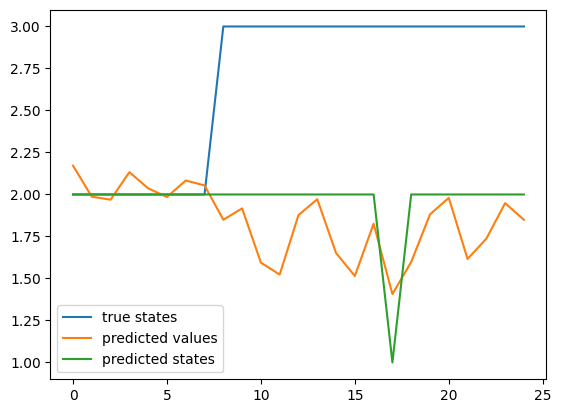

In [12]:
# view plot of an individual subject's results
s = 1
plt.plot(testing.index, testing[str(s)].astype('int'), label="true states")
plt.plot(testing.index, predictions[str(s)], label="predicted values")
plt.plot(testing.index, round(predictions[str(s)]).astype('int'), label="predicted states")
plt.legend()

In [13]:
plt.savefig("arima_25_" +str(s)+".pdf", format="pdf", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

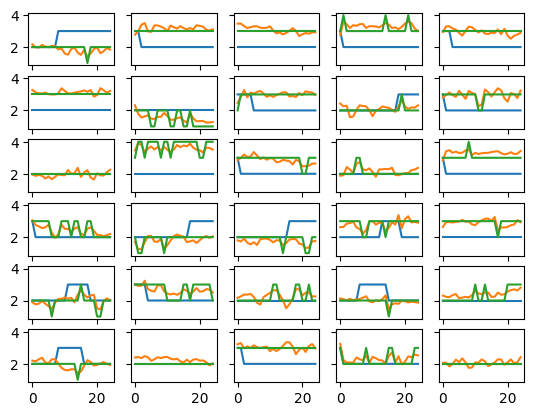

In [14]:
# view plots of results for all subjects
fig, axs = plt.subplots(6, 5, sharex=True, sharey=True)

# initialize subject 1
subject = 1
# plot each set of results
for row in range(0,6):
    for col in range(0,5):
        axs[row, col].plot(testing.index, testing[str(subject)].astype('int'), label="true states")
        axs[row, col].plot(testing.index, predictions[str(subject)], label="predicted values")
        axs[row, col].plot(testing.index, round(predictions[str(subject)]).astype('int'), label="predicted states")
        subject = subject + 1

# hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [15]:
fig.savefig("arima_25.pdf", format="pdf", bbox_inches="tight")

### Results: Accuracy

In [16]:
# Accuracy
# create empty dataframe to store accuracy
accuracy = pd.DataFrame()

# get accuracy using the classification report from sklearn
for i in range(1,31):
    rep_i = classification_report(testing[str(i)].astype('string'), 
                          round(predictions[str(i)]).astype('int').astype('str'))
    acc_i = float(re.findall("accuracy.*[01].\d\d",rep_i)[0][-4:])
    accuracy.at[i,"accuracy"] = acc_i

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/var/folders/6g/lht9tm8x1bz3sdrs0xk_d2m00000gn/T/ipykernel_29457/707666640.py:9: SyntaxWarning: invalid escape sequence '\d'
  acc_i = float(re.findall("accuracy.*[01].\d\d",rep_i)[0][-4:])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frame

In [17]:
accuracy.mean()

accuracy    0.430667
dtype: float64

In [18]:
accuracy.describe()

,accuracy
count,30.000000
mean,0.430667
std,0.348662
min,0.000000
25%,0.090000
50%,0.460000
75%,0.710000
max,1.000000


### Results: AIC

In [19]:
aic.mean()

aic    32.774165
dtype: float64

In [20]:
aic.describe()

,aic
count,30.000000
mean,32.774165
std,84.579168
min,-238.540767
25%,8.368422
50%,51.103905
75%,82.974953
max,194.868137
